## TMDB - Systematische Evaluierung

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

In [3]:
# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


In [4]:
# extract data from dictionaries and list, separate key values by '|'

def extract_values(data):
    return data.apply(lambda x: '|'.join([i['name'] for i in eval(x)]))

df_movies['genres'] = extract_values(df_movies["genres"])
df_movies['spoken_languages'] = extract_values(df_movies["spoken_languages"])
df_movies['production_companies'] = extract_values(df_movies['production_companies'])
df_movies['production_countries'] = extract_values(df_movies['production_countries'])

# belongs_to_collection

In [5]:
# define columns that are not usefull
# adult is dropped because there are only 3 adult films. which makes it useless to use for our model
cols = [
    "imdbId",
    "Unnamed: 0",
    "backdrop_path",
    "homepage",
    "poster_path",
    "imdb_id",
    "original_title",
    "video",
    "status",
    "adult"
]

# drop columns defined above
df_movies = df_movies.drop(df_movies[cols], axis=1)

In [6]:
# reorder columns for better overview
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "tagline",
    "release_date", 
    "vote_average", 
    "vote_count", 
    "popularity", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
    "revenue",
    "budget",
    "belongs_to_collection", 
]

df_movies = df_movies[col_order]

In [7]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df_movies = df_movies.drop_duplicates(subset=df_movies.columns.difference(["movieId"]))

In [8]:
# replace empty field with np.nan
df_movies = df_movies.replace("", np.nan)

In [9]:
# print number of NA's in each column
print(df_movies.isna().sum())

movieId                      0
title                        0
genres                     320
overview                   161
tagline                  11164
release_date                 0
vote_average                 0
vote_count                   0
popularity                   0
runtime                      0
original_language            0
spoken_languages          1131
production_companies      3610
production_countries      1869
revenue                      0
budget                       0
belongs_to_collection    18069
dtype: int64


In [10]:
# Pre-processing the overview data before feeding it to the model

# drop rows with NAN overview --> overview is very important for the recommender model
df_movies = df_movies.dropna(subset=["overview"])

# lowercase column overview
df_movies["overview"] = df_movies["overview"].str.lower()

# remove punctuation from overview
symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"

# replace all punctuations from overview with space
for i in symbols:
    df_movies["overview"] = df_movies["overview"].str.replace(i, ' ')
    
# replace all single words from overview with space
df_movies["overview"] = df_movies["overview"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')

C:\Users\Alex\AppData\Local\Temp/ipykernel_13340/2538519478.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_movies["overview"] = df_movies["overview"].str.replace(i, ' ')
C:\Users\Alex\AppData\Local\Temp/ipykernel_13340/2538519478.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_movies["overview"] = df_movies["overview"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')


In [11]:
# stemm overview words to stem words
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

df_movies["overview"] = df_movies["overview"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
df_movies["overview"].head()

0     an atmospher come of age stori featur an imagi...
4     the town of derri has secret, but no one told ...
5     as her surround are invad by outsiders, the fa...
6     use person stories, this power documentari ill...
10    she as hot as britney spear hotter she parti l...
Name: overview, dtype: object

In [12]:
df_movies

,movieId,title,genres,overview,tagline,release_date,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection
0,895,Venice,Drama|Romance,an atmospher come of age stori featur an imagi...,NaN,2010-06-11,7.000,13,1.246,110,pl,Český|Deutsch|Polski|Pусский,Akson Studio|ITI Cinema,Poland,0,1783810,NaN
4,1115,The Sleepover,Comedy|Horror,"the town of derri has secret, but no one told ...",NaN,2012-10-12,6.600,8,0.600,6,en,English,NaN,United States of America,0,0,NaN
5,2223,The Farmer's Wife,Drama,"as her surround are invad by outsiders, the fa...",NaN,2012-06-20,10.000,1,0.600,18,en,English,NaN,NaN,0,0,NaN
6,2679,A Place at the Table,Documentary,"use person stories, this power documentari ill...",One Nation. Underfed.,2012-03-22,6.700,20,2.337,84,en,English,NaN,United States of America,0,0,NaN
10,2894,Romance,Romance|Drama|Comedy,she as hot as britney spear hotter she parti l...,NaN,2012-10-09,6.000,1,1.080,27,en,English,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19973,209133,The Riot and the Dance: Earth,Documentary,"this natur scienc documentary, showcas the vas...",A Cinematic Celebration of Creation,2018-03-19,3.500,2,0.600,110,en,NaN,NaN,NaN,0,0,NaN
19974,209143,The Painting,Documentary|History|Animation,"for three and half centuries, from the same da...",What is happening in that room?,2019-11-08,8.000,2,0.600,107,es,English|Français|Italiano|Español,TVE|TeleMadrid|Mare Films,Spain,0,0,NaN
19975,209145,Liberte,Drama|History,"1774, short befor the french revolution, somew...",NaN,2019-09-04,5.400,22,3.829,132,fr,Français|Italiano|Deutsch,CNC|Medienboard Berlin-Brandenburg|Idéale Audi...,Germany|Spain|France|Portugal,0,0,NaN
19977,209157,We,Drama,dure scorch summer in belgian dutch border vil...,NaN,2018-07-12,5.938,56,6.512,100,nl,Nederlands,New AMS Film Company,Belgium|Netherlands,0,0,NaN


## User Profiles

In [13]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

In [14]:
lst_movieId = list(df_movies["movieId"])

# remove ratings from movies that we are not using
df_ratings = df_ratings[df_ratings["movieId"].isin(lst_movieId)]

# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

# merge movies and ratings
df_movies_ratings = pd.merge(df_ratings, df_movies, on = "movieId")

In [15]:
# drop rows where the ratings were submitted before the movie released
df_movies_ratings = df_movies_ratings[df_movies_ratings["date"] > df_movies_ratings["release_date"]]

# drop columns because they are useless now
df_movies_ratings.drop(["date", "release_date"], axis = 1, inplace = True)

In [16]:
# No user has rated the same movie twice
df_movies_ratings[df_movies_ratings.duplicated(subset=["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection


In [17]:
df_movies_ratings

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652411,162067,200634,2.5,Eddie's Life Coach,Family|Animation,eddi mom sign her slacker son up for digit tra...,NaN,5.500,6,1.691,4,en,English,Illumination,United States of America,0,0,NaN
2652412,162358,200168,3.0,Overtime War,Action|Comedy,benefit and day off in war,NaN,6.500,2,0.600,5,sv,svenska,Crazy Pictures,Sweden,0,0,NaN
2652413,162358,200172,4.0,Du ritar fult,Drama,"you can draw , said the classmat he didn know ...",NaN,6.750,8,0.869,6,sv,NaN,Crazy Pictures,Sweden,0,0,NaN
2652414,162358,200182,4.0,Kuken brinner,Drama,ander is in the hospit wait nervous for test r...,NaN,6.000,3,0.600,6,sv,svenska,Crazy Pictures,Sweden,0,0,NaN


In [18]:
df_movies_ratings[df_movies_ratings["title"] == "Du ritar fult"]["rating"].count()

1

In [19]:
# group by title and count ratings
df_movies_top_ratings = df_movies_ratings.groupby("title")["rating"].count().sort_values(ascending = False).reset_index()
df_movies_top_ratings

# show movies with more than 10 ratings (only 6.6k movies)
df_movies_10_ratings = df_movies_top_ratings[df_movies_top_ratings["rating"] > 10]
df_movies_10_ratings

,title,rating
0,Inception,38895
1,Interstellar,22634
2,Django Unchained,20686
3,The Dark Knight Rises,19911
4,Shutter Island,18886
...,...,...
6616,Generation Iron 2,11
6617,Luce,11
6618,Serial Killer 1,11
6619,The Dish & the Spoon,11


In [20]:
# reduce df_movies_ratings to movies with more than 10 ratings summed up
df_movies_ratings = df_movies_ratings[df_movies_ratings["title"].isin(df_movies_10_ratings["title"])]
df_movies_ratings

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652321,157975,138448,3.0,Midnight Sun,Family|Adventure,"in northern canada, young boy set goal for him...","The Most Amazing Story Of Survival, Friendship...",6.100,66,5.625,98,en,English,Hyde Park Films|Imagenation Abu Dhabi FZ|Media...,Italy|Canada,3016126,12758853,NaN
2652327,158109,179343,3.5,The Man from the Future,Comedy,onli fifti minut to go until the end of the wo...,NaN,4.700,3,0.600,75,ru,Pусский,CTB Film Company,Russia,0,0,NaN
2652341,158727,202409,3.0,One Day,Fantasy|Drama,"man, who wit his wife suicide, gradual cure hi...",Only I could see her...,6.700,17,4.789,114,ko,한국어/조선말,Opus Pictures|Invent Stone|CGV Arthouse,South Korea,0,0,NaN
2652357,159380,146540,3.5,Boy,Drama,16 year old emili has alway been boy insid his...,NaN,5.500,6,0.600,16,da,Dansk,Station Next,Denmark,0,0,NaN


## Testing

In [21]:
# Programmierungs Fragen
# tagline more relevant then overview?
# 300 + movies with 0 runtime
# amount of ratings --> drop movies with under 10 vote counts?? (results in 6600 movies)
# Many movies with 0 revenue and 0 budget

# Generelle Fragen
# Wie beheben wir das Cold Start Problem?

## EDA

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 1. Welches sind die am häufigsten geschauten Genres/Filme?


In [23]:
# separate genres and add them as columns, 0 = not in genre, 1 = in genre
dum = df_movies_ratings['genres'].str.get_dummies(sep = '|')
df_genres = pd.concat([df_movies_ratings, dum], axis=1)
df_genres.head()

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"post apocalypt tale, in which lone man fight h...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0


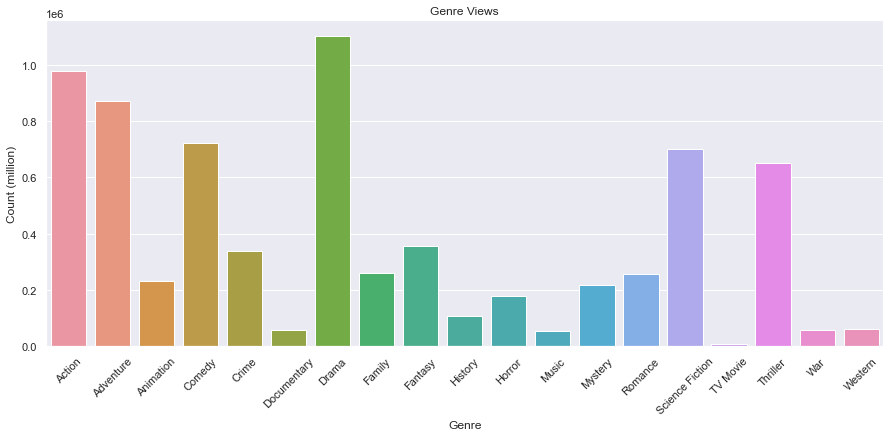

In [24]:
sns.set(rc={'figure.figsize':(15,6)})

ax = sns.barplot(data = df_genres.iloc[:,-19:].sum().reset_index(), x = "index", y = 0)
ax.set(xlabel='Genre', ylabel='Count (million)', title="Genre Views")
plt.xticks(rotation = 45)
plt.show()

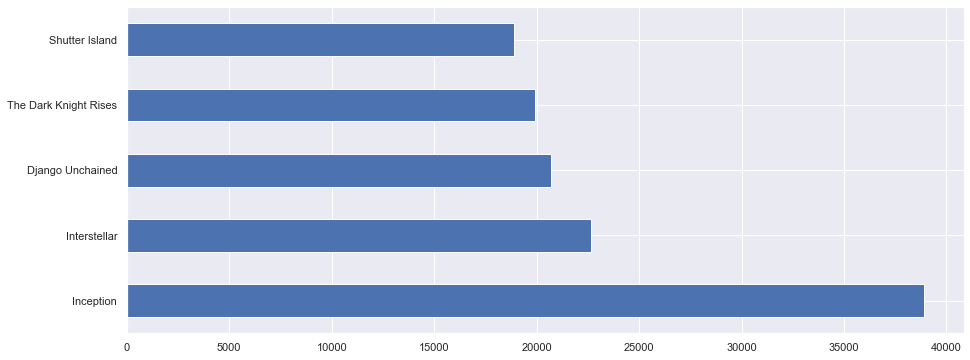

In [25]:
df_movies_ratings['title'].value_counts()[:5].plot(kind = "barh")
plt.show()

#### 2. Wie verteilen sich die Kundenratings gesamthaft und nach Genres?


In [26]:
# create 2d list with genre and all ratings
lst2 = []
for i in df_genres.iloc[:,-19:].columns:
    lst2.append([i, df_genres[df_genres[i] == 1]["rating"].tolist()])

# create dataframe from lst2 and unpack the list of ratings
df_genres_ratings = pd.DataFrame(lst2, columns = ["Genre", "Rating"])
df_genres_ratings = df_genres_ratings.explode("Rating")
df_genres_ratings.head()

,Genre,Rating
0,Action,4.0
0,Action,3.5
0,Action,3.0
0,Action,5.0
0,Action,5.0


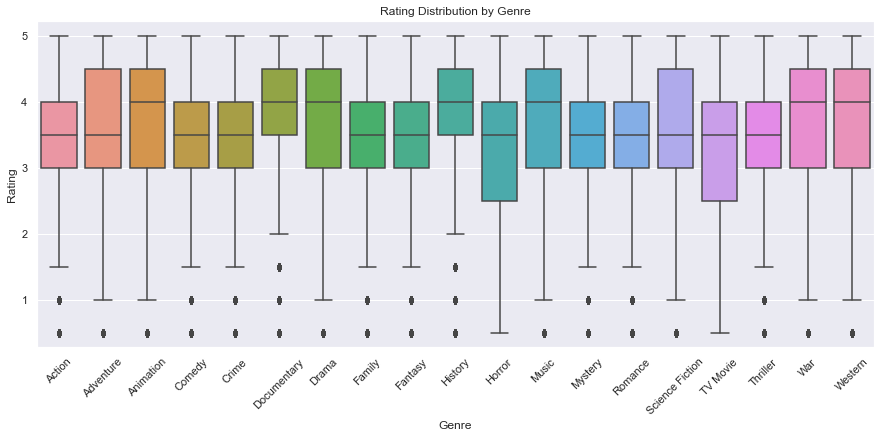

In [27]:
# plot rating by genre
sns.set(rc={'figure.figsize':(15,6)})
ax = sns.boxplot(data = df_genres_ratings, x = "Genre", y = "Rating")
ax.set(xlabel='Genre', ylabel='Rating', title="Rating Distribution by Genre")
plt.xticks(rotation = 45)
plt.show()

#### 3. Wie verteilen sich die mittleren Kundenratings pro Film?

<AxesSubplot:ylabel='Frequency'>

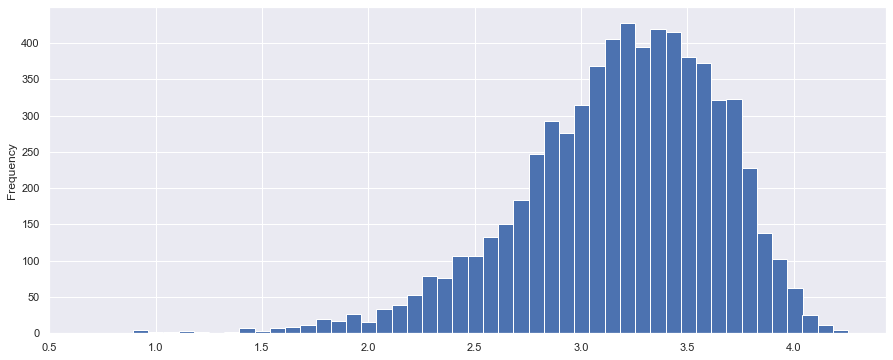

In [28]:
# group df4 by title and plot average rating
df_genres.groupby("title")["rating"].mean().sort_values(ascending = False).plot(kind = "hist", bins = 50)

#### 4. Wie stark streuen die Ratings von individuellen Kunden?

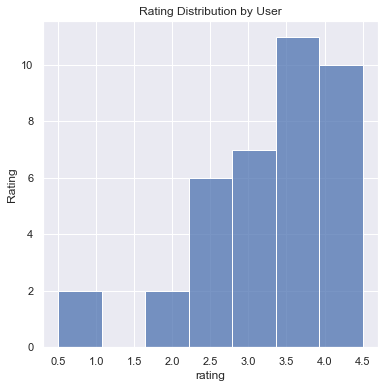

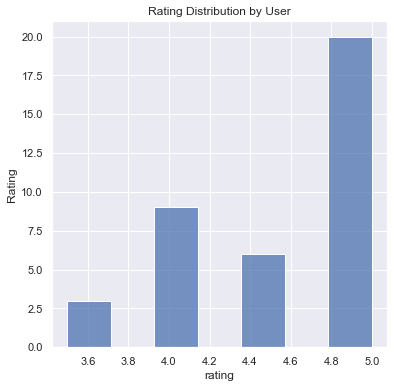

In [29]:
def user_rating(id):
    # seaborn boxplot ratings from random user
    sns.set(rc={'figure.figsize':(6,6)})

    ax = sns.histplot(data = df_genres[df_genres["userId"] == id], x = "rating")
    ax.set(ylabel='Rating', title="Rating Distribution by User")
    plt.show()

user_rating(13)
user_rating(44)

### NLP Implementierung

Was macht tf-idf mit Wörter, die überall vorkommen? 
- diese Wörter werden tief gewichtet

Was passiert mit Wörter die sehr selten sind? kann das Wort überahupt zur Ähnlichkeit beitragen?
- Wörter, die selten vorkommen haben ein höheres Score (höher bewertet)

Synonyme: Word2Vec (zb Auto --> PKW)

Verteilung der Ähnlichkeiten

aus dem text vektoren machen

was passiert mit dem cosinum similarity wenn wir die seltesten wörter abschneiden? besser? schlechter?

auf grund der häufigkeit matrix reduzieren

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

In [30]:
# create dataframe with 2 movies for testing
df_movies_20 = df_movies_10_ratings.head(1000).reset_index(drop=True)

## TF-IDF
TfidfVectorizer --> convert a collection of text documents to a matrix of TF-IDF features
- Welche Gewichtung hat das Wort im Overview --> df_tfidf_vect

CountVectorizer --> convert a collection of text documents to a vector of term / token counts
- Zählt, ob das Wort im Overview vorkommt

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vectorizer = CountVectorizer(stop_words="english", analyzer = "word")
tfidf_vectorizer = TfidfVectorizer(stop_words="english", analyzer = "word", ngram_range=(1, 1))

# convert the overviews (documents) into a matrix
word_count_matrix = count_vectorizer.fit_transform(df_movies_20["overview"])
tfidf_word_matrix = tfidf_vectorizer.fit_transform(df_movies_20["overview"])

# get the feature names of the count matrix (words)
word_array = count_vectorizer.get_feature_names_out()
tfidf_tokens = tfidf_vectorizer.get_feature_names_out()

KeyError: 'overview'

In [ ]:
# word score for each movie
tfidf_word_matrix

<18000x36334 sparse matrix of type '<class 'numpy.float64'>'
	with 465270 stored elements in Compressed Sparse Row format>

In [ ]:
word_count_matrix

<18000x36334 sparse matrix of type '<class 'numpy.int64'>'
	with 465270 stored elements in Compressed Sparse Row format>

### Welche Wörter kommen am häufigsten vor?

In [ ]:
print([word_array[i] for i in np.argsort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5]])
print(np.sort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5])

['life', 'year', 'live', 'world', 'new']
[1161, 861, 751, 740, 709]


### Cosine Similarity
![Getting Started](./cosine_similarity.png)

In [ ]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

sparse_matrix = sparse.csr_matrix(tfidf_word_matrix)

# calculate the cosine similarity
cosine_sim = cosine_similarity(sparse_matrix)

# recommend most similar movies
def recommend_movies(title, cosine_sim = cosine_sim):
    # get the index of the movie that matches the title
    idx = df_movies_20[df_movies_20["title"] == title].index[0]
    
    # create a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    # get the indexes of the 5 most similar movies
    top_10_indexes = list(score_series.iloc[1:6].index)
    
    # Populate the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        print(df_movies_20.iloc[i]["title"], ":", score_series[i])

recommend_movies("Venice")


Miss Bala : 0.14295434893162828
Declaration of War : 0.13670554759152484
Six Degrees of Celebration : 0.130339752163739
October Baby : 0.12178445494654352
That's What I Am : 0.11122900975244701


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# tfidf_matrix contains each word and its importance (tf-idf score)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies_20["overview"])

# cosine similarity
cosine_similarities = cosine_similarity(tfidf_matrix) 

# get the feature names of the count matrix (words)
tfidf_tokens = tfidf_vectorizer.get_feature_names_out()

# create a dataframe from the tfidf_matrix
df_tfidfvect = pd.DataFrame(cosine_similarities, index=df_movies_20['title'], columns=df_movies_20['title'])
df_tfidfvect.head()

title,Venice,The Sleepover,The Farmer's Wife,A Place at the Table,Romance,Kingdom Come,"Camille Claudel, 1915",My Kingdom,Luster,Black Gold,The Scar,Giant,"Police, Adjective",Leap Year,The Book of Eli,If You Love,Legion,Dante's Hell Animated,Extraordinary Measures,Backwood Philosopher
title,,,,,,,,,,,,,,,,,,,,
Venice,1.000000,0.000000,0.000000,0.000000,0.061039,0.019857,0.000000,0.037402,0.000000,0.099170,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.049639,0.017150,0.000000
The Sleepover,0.000000,1.000000,0.000000,0.055265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.059059,0.048496,0.000000,0.000000,0.000000,0.000000
The Farmer's Wife,0.000000,0.000000,1.000000,0.062799,0.000000,0.000000,0.000000,0.019829,0.051054,0.093750,0.000000,0.000000,0.0,0.022534,0.000000,0.033840,0.023079,0.000000,0.038621,0.000000
A Place at the Table,0.000000,0.055265,0.062799,1.000000,0.000000,0.023649,0.000000,0.010145,0.027000,0.013461,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.016630,0.000000
Romance,0.061039,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.053079,0.000000,0.043505,0.000000,0.000000,0.000000
Kingdom Come,0.019857,0.000000,0.000000,0.023649,0.000000,1.000000,0.000000,0.007224,0.019226,0.025719,0.000000,0.000000,0.0,0.016971,0.000000,0.000000,0.000000,0.033306,0.026386,0.000000
"Camille Claudel, 1915",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.041511,0.059970,0.014949,0.000000,0.063811,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
My Kingdom,0.037402,0.000000,0.019829,0.010145,0.000000,0.007224,0.041511,1.000000,0.000000,0.059635,0.000000,0.000000,0.0,0.000000,0.016353,0.010933,0.020071,0.004764,0.012478,0.000000
Luster,0.000000,0.000000,0.051054,0.027000,0.000000,0.019226,0.059970,0.000000,1.000000,0.007477,0.032431,0.000000,0.0,0.015776,0.059649,0.000000,0.000000,0.008406,0.033209,0.025496


In [ ]:
def get_recommendations(title, cosine_similarities = cosine_similarities):
    # Get the index of the movie that matches the title
    idx = df_movies_20[df_movies_20['title'] == title].index[0]

    # Create a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # Get the indexes of the 5 most similar movies
    top_10_indexes = list(score_series.iloc[1:6].index)

    # Populate the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        print(df_movies_20.iloc[i]["title"], ":", score_series[i])

get_recommendations("Venice")

Black Gold : 0.09917012896183794
Romance : 0.0610394633685531
Dante's Hell Animated : 0.04963941366838312
My Kingdom : 0.03740163486572886
Kingdom Come : 0.019857497679942198


In [ ]:
# print overviews from selected movies
# df_movies[df_movies["title"].isin(["Interstellar", "Immortals"])][["title", "overview"]].values

array([['Immortals',
        'theseus is mortal man chosen by zeus to lead the fight against the ruthless king hyperion, who is on rampag across greec to obtain weapon that can destroy human'],
       ['Interstellar',
        'the adventur of group of explor who make use of newli discov wormhol to surpass the limit on human space travel and conquer the vast distanc involv in an interstellar voyag']],
      dtype=object)

In [ ]:
### tfidf gewichtung
### word2vec ein vektor für ein einzelnes wort
# embedings und global average

## Evaluierung
